In [ ]:
#  Core libraries
import os
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import matplotlib.pyplot as plt

#  Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Label mapping
label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}
id_to_label = {v: k for k, v in label_to_id.items()}


In [112]:
csv_path = "/Users/raj/Downloads/classtapad.csv"  # Change this
df = pd.read_csv(csv_path)

# Clean whitespace or NaNs
df = df.dropna()
df["Word"] = df["Word"].str.strip()
df["Class"] = df["Class"].str.strip()

# Create mapping: filename → label
label_map = dict(zip(df["Word"] + ".mp3", df["Class"]))


In [113]:
mel_transform = MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=320,
    n_mels=128
)

db_transform = AmplitudeToDB(top_db=80)


In [116]:
import glob

class WordAudioDataset(Dataset):
    def __init__(self, audio_dir, label_map, transform=None):
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}


        # Recursively find all mp3 files under audio_dir
        all_audio_files = glob.glob(os.path.join(audio_dir, "**/*.mp3"), recursive=True)
        self.files = [f for f in all_audio_files if os.path.basename(f) in label_map]
        self.label_map = label_map


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < 10:
            try:
                path = self.files[idx]
                filename = os.path.basename(path)
                label = self.label_to_id[self.label_map[filename]]



                if not os.path.exists(path):
                    raise FileNotFoundError(f"Missing: {path}")

                waveform, sr = torchaudio.load(path)

                if waveform.shape[1] < 16000:
                    waveform = F.pad(waveform, (0, 16000 - waveform.shape[1]))
                else:
                    waveform = waveform[:, :16000]

                mel = self.transform(waveform)
                mel = AmplitudeToDB(top_db=80)(mel)
                mel = torch.nn.functional.interpolate(mel.unsqueeze(0), size=(224, 224), mode="bilinear").squeeze(0)

                return mel, label


            except Exception as e:
                print(f"⚠️ Skipping sample {idx} ({file}): {e}")
                idx = (idx + 1) % len(self.files)
                attempts += 1

        raise RuntimeError("Too many consecutive loading failures.")


In [117]:
audio_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/Dataset"  # 🔁 Change this
dataset = WordAudioDataset(audio_dir, label_map, transform=mel_transform)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset, batch_size=16, shuffle=False)


In [ ]:
import timm
import torch.nn as nn

model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
model.head = nn.Linear(model.head.in_features, len(label_to_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [ ]:
best_acc = 0

for epoch in range(20):
    model.train()
    total_loss = 0

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)
        # mel is already [B, 1, H, W] from Dataset

        optimizer.zero_grad()
        output = model(mel)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    #  Evaluation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            output = model(mel)

            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=list(id_to_label.keys())), all_probs, multi_class='ovr') * 100
        auc_str = f"{auc:.2f}"
    except:
        auc_str = "N/A"

    print(f" Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")
    
    from sklearn.utils.multiclass import unique_labels

    present_labels = unique_labels(all_labels, all_preds)
    target_names = [id_to_label[l] for l in present_labels]
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    #  Save best
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_astv2_wordlevel.pth")
        print(f" Saved best model with accuracy: {round(best_acc, 2)}")

    scheduler.step()


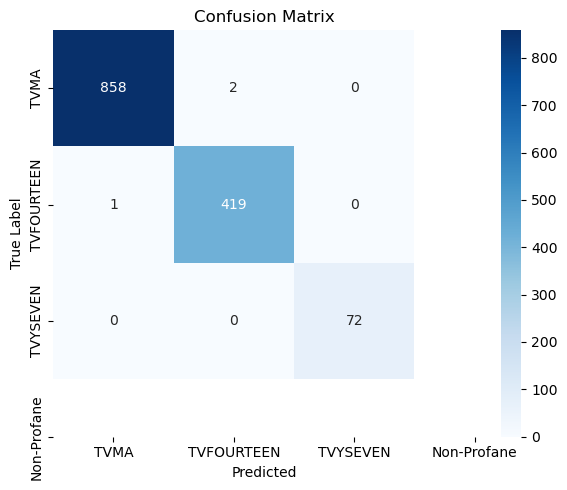

In [121]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(4)],
            yticklabels=[id_to_label[i] for i in range(4)])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# Update to your path
model_path = "best_astv2_wordlevel.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval().to(device)

# Mel transforms
sample_rate = 16000
mel_transform = MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=320, n_mels=128)
db_transform = AmplitudeToDB(top_db=80)

# Labels
label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}
id_to_label = {v: k for k, v in label_to_id.items()}


In [123]:
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=1.0, stride_sec=0.5, threshold=0.5):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono

    window_samples = int(window_sec * sample_rate)
    stride_samples = int(stride_sec * sample_rate)
    total_samples = waveform.shape[1]

    predictions, confidences, segments = [], [], []

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)
            mel_db = mel_db.unsqueeze(0)  # [1, 1, H, W]

            if mel_db.shape[-1] < 10:
                predictions.append(None)
                confidences.append(None)
                segments.append((start, end))
                continue

            mel_resized = torch.nn.functional.interpolate(mel_db, size=(224, 224), mode='bilinear', align_corners=False)
            output = model(mel_resized.to(device))
            probs = torch.softmax(output, dim=1).cpu().squeeze()
            conf, pred = torch.max(probs, dim=0)

            predictions.append(pred.item() if conf >= threshold else None)
            confidences.append(conf.item() if conf >= threshold else None)
            segments.append((start, end))

    return waveform.squeeze().numpy(), segments, predictions, confidences


In [124]:
import matplotlib.pyplot as plt
from IPython.display import Audio

def plot_predictions(waveform_np, segments, predictions, confidences, sr=sample_rate):
    plt.figure(figsize=(14, 4))
    plt.plot(waveform_np, alpha=0.7)
    
    for (start, end), label_id, conf in zip(segments, predictions, confidences):
        if label_id is not None:
            label = id_to_label[label_id]
            plt.axvspan(start, end, color='red', alpha=0.2)
            plt.text((start + end) // 2, 0.5, f"{label}\n({conf:.2f})",
                     color='red', fontsize=10, rotation=90, ha='center', va='bottom')
    
    plt.title("Predicted Labels per Segment (with Confidence)")
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


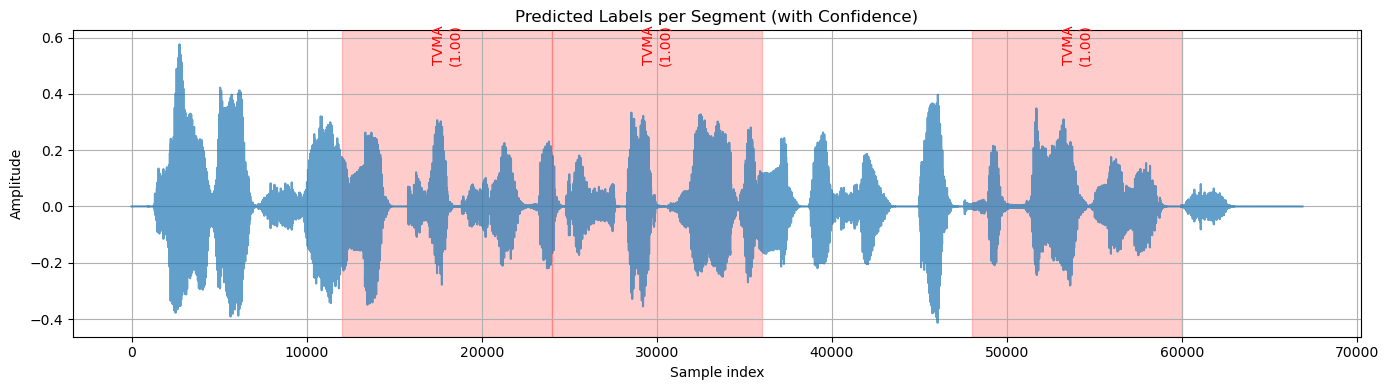

In [ ]:
#  Replace with your test file path
audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/newdata/new/line_690.mp3"

# audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/non_profane/3174_non_profane.mp3"

waveform_np, segments, predictions, confidences = predict_on_audio(
    audio_path, model, mel_transform, db_transform, device,
    window_sec=.75, stride_sec=0.75, threshold=.99
)

plot_predictions(waveform_np, segments, predictions, confidences)
Audio(audio_path)


In [130]:
import numpy as np

def apply_beep_on_predictions(waveform, sample_rate, segments, predictions, labels_to_beep, beep_freq=1000, gain_db=-5):
    waveform = waveform.clone() if torch.is_tensor(waveform) else torch.tensor(waveform).unsqueeze(0)

    # Create a simple sine wave beep of 1 sec
    beep = torch.sin(2 * np.pi * beep_freq * torch.arange(0, 1.0, 1.0 / sample_rate))
    beep = beep.unsqueeze(0)  # [1, time]
    beep = beep * (10 ** (gain_db / 20))  # Adjust gain

    for (start, end), label_id in zip(segments, predictions):
        if label_id is None:
            continue

        label = id_to_label[label_id]
        if label not in labels_to_beep:
            continue

        # Convert sample indices
        duration = end - start
        beep_resized = torch.nn.functional.interpolate(beep.unsqueeze(0), size=duration, mode='linear').squeeze(0)

        # Apply the beep
        waveform[:, start:end] = beep_resized[:, :duration]

    return waveform


In [ ]:
labels_to_beep = ["TVMA", "TVFOURTEEN", "TVYSEVEN"]  # You can adjust this
waveform_tensor = torch.tensor(waveform_np).unsqueeze(0)

beeped_waveform = apply_beep_on_predictions(waveform_tensor, sample_rate, segments, predictions, labels_to_beep)

#  Save it if you want
output_path = "beeped_output123.wav"
torchaudio.save(output_path, beeped_waveform, sample_rate)
print(f" Saved to: {output_path}")

# Play it in notebook
from IPython.display import Audio
Audio(output_path)


✅ Saved to: beeped_output123.wav
